## Introduction<a id='Introduction'></a>

The purpose of this notebook will be to preprocess our data to get it ready for Machine Learning. 

    1. Create dummy or indicator features for categorical variables
    2. Split your data into testing and training datasets
    3. Standardize the magnitude of numeric features using a scaler

## Table of Contents<a id='Table_of_Conents'></a>

* [Introduction](#Introduction)
* [Table of Contents](#Table_of_Contents)
* [Imports](#Imports)
* [View Data](#View_Data)
* [Create Dummy Columns](#Create_Dummy_Columns)
* [Train Test Split](#Train_Test_Split)
* [Baseline Model](#Baseline_Model)
* [Modeling](#Modeling)
* [Conclusion](#Conclusion)

## Imports<a id='Imports'></a>

Here we are importing the necessary libraries as well as the data to help with preprocessing and to get a basic machine learning model created for the dataset. We also read in the data into data dataframe and define a function to plot a confusion matrix to be used later. 

In [1]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyRegressor

#Don't display future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set()

In [2]:
#Import cleaned data
data = pd.read_csv('data/clean_data/clean_data.csv')

In [3]:
def plot_confusion_matrix(y_test, y_pred):

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    classes = ['uncommon', 'common']

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # Add labels to each cell
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

## View Data<a id='View_Data'></a>

Here we will make some adjustments to the dataset so we have all the right data types/values that we need. 

In [4]:
#Update the data type to Strings for Product Code as they are categories, not ints. 
data['ProductCode'] = data['ProductCode'].values.astype('str')

#product codes: 1293 (amusement devices), 3295 (water slides, public), and 3259 (go-karts).
#Update the product codes values to align with their actual meaning. 

#Create a dictionary for the product codes
product_codes = {'1293':'amusement devices (1293)', '3295': 'water slides, public (3295)', '3259':'go-karts (3259)'}

#Update the product code to the proper strings
data.replace(product_codes, inplace=True)

#Convert to Date Time object
data['Treatment_Date'] = pd.to_datetime(data['Treatment_Date'])

In [5]:
data.set_index('CPSC_Case_Number', inplace = True)

We have also set the Case Number as the index since it is a unqiue identifier of the data. Let's look at the current data types for the remaining columns. 

In [6]:
data.dtypes

Treatment_Date     datetime64[ns]
Age                         int64
Sex                        object
Narrative                  object
Diagnosis                  object
Other_Diagnosis            object
BodyPart                   object
Disposition                object
ProductCode                object
Device_category            object
Device_type                object
Location                   object
Stratum                    object
PSU                         int64
Weight                    float64
dtype: object

Here we see that everything is a string except for Age, PSU, and Weight. No information was available for what PSU and Weight actually mean so I will leave them alone for now. Let's veiw the data to make sure it looks acceptable. 

In [7]:
data.head()

,Treatment_Date,Age,Sex,Narrative,Diagnosis,Other_Diagnosis,BodyPart,Disposition,ProductCode,Device_category,Device_type,Location,Stratum,PSU,Weight
CPSC_Case_Number,,,,,,,,,,,,,,,
180125260,2017-12-31,3,F,3 YOF JUMPING BOUNCE HOUSE W/MOM JUMPED UP LAN...,Fracture,NaN,"Leg, lower",Treated and released,amusement devices (1293),Inflatables,inflatable,Sports/recreation,C,32,4.7570
180108428,2017-12-31,10,F,10YOF PLAYING *** AT *** AT A PARTY AT *** LOC...,Dental injury,NaN,Mouth,Treated and released,amusement devices (1293),Not identified or unrelated,not identified,Sports/recreation,C,8,4.7570
180120413,2017-12-31,14,M,14YOM- PT WAS PLAYING *** TODAY SWELLING TO RI...,Other,TENDONITIS,Knee,Treated and released,amusement devices (1293),Not identified or unrelated,not identified,Sports/recreation,C,90,4.7570
180125238,2017-12-30,2,F,2 YOF JUMPING IN BOUNCE HOUSE LANDED AWKWARDLY...,Fracture,NaN,"Leg, lower",Treated and released,amusement devices (1293),Inflatables,inflatable,Sports/recreation,C,32,4.7570
180135290,2017-12-30,17,F,"17YOF DRIVING GO CART, RAN INTO BARRIER, HIT L...","Strain, sprain",NaN,Hand,Treated and released,go-karts (3259),Go karts,go kart,Sports/recreation,M,54,79.1731


## Create Dummy Columns<a id='Create_Dummy_Columns'></a>

Let's now convert the data into dummy variable columns so that all the categorical columns are split out as 0 or 1 as opposed to strings. The first thing we will do is drop the Disposition column as we will be predicting the injury Diagnosis, so the Disposition will not have any impact on that since it occurs after the diagnosis. Then we will create all the necessary dummy columns. Then we will convert the "Treatment_Day" field into new columns for day, month, and year and drop the main Treatment Date. Lastly, we will drop the "Narrative" field as it will not be used with the machine learning algorithms.

In [8]:
#Not including Diagnosis as that is the first prediction. 'Diagnosis'
#Not including 'Other_Diagnosis' as that value is derived from the Diagnosis column. 
d_data = pd.get_dummies(data, columns= ['Sex', 'BodyPart', 
                               'ProductCode', 'Device_category', 
                               'Device_type', 'Location', 'Stratum'], drop_first=True)

#Need to convert the treatment date to Day, Month, and Year
d_data['Treatment_Day'] = d_data['Treatment_Date'].dt.day
d_data['Month_Day'] = d_data['Treatment_Date'].dt.month
d_data['Year_Day'] = d_data['Treatment_Date'].dt.year

In [9]:
d_data.head()

,Treatment_Date,Age,Narrative,Diagnosis,Other_Diagnosis,Disposition,PSU,Weight,Sex_M,BodyPart_Ankle,...,Location_Sports/recreation,Location_Street,Location_Unknown,Stratum_L,Stratum_M,Stratum_S,Stratum_V,Treatment_Day,Month_Day,Year_Day
CPSC_Case_Number,,,,,,,,,,,,,,,,,,,,,
180125260,2017-12-31,3,3 YOF JUMPING BOUNCE HOUSE W/MOM JUMPED UP LAN...,Fracture,NaN,Treated and released,32,4.7570,0,0,...,1,0,0,0,0,0,0,31,12,2017
180108428,2017-12-31,10,10YOF PLAYING *** AT *** AT A PARTY AT *** LOC...,Dental injury,NaN,Treated and released,8,4.7570,0,0,...,1,0,0,0,0,0,0,31,12,2017
180120413,2017-12-31,14,14YOM- PT WAS PLAYING *** TODAY SWELLING TO RI...,Other,TENDONITIS,Treated and released,90,4.7570,1,0,...,1,0,0,0,0,0,0,31,12,2017
180125238,2017-12-30,2,2 YOF JUMPING IN BOUNCE HOUSE LANDED AWKWARDLY...,Fracture,NaN,Treated and released,32,4.7570,0,0,...,1,0,0,0,0,0,0,30,12,2017
180135290,2017-12-30,17,"17YOF DRIVING GO CART, RAN INTO BARRIER, HIT L...","Strain, sprain",NaN,Treated and released,54,79.1731,0,0,...,1,0,0,0,1,0,0,30,12,2017


We see that our columns are now converted to 0 or 1 for each category and has a 1 if it has that specific value. We dropped the first column of each category so there is no duplicate data. 

Let's now split the Diagnosis column into 2 specific categories to simplify the model for now. We will use "Common" and "Uncommon" so we can predict what types of situations contribute to the most common injuries so safegaurds can be taken to try to prevent these types of injuries moving forward. The three common types will be the top three most common injuries which is "Strain, sprain", "Fracture", and "Contusion, abrasion". Everything else will be considered uncommon. 

In [10]:
d_data['Diagnosis'].value_counts()

Strain, sprain                1391
Fracture                      1280
Contusion, abrasion           1030
Other                          986
Laceration                     660
Internal injury                540
Concussion                     233
Dislocation                    140
Dental injury                   73
Hematoma                        48
Burn, thermal                   43
Dermatitis, conjunctivitis      33
Crushing                        22
Avulsion                        21
Foreign body                    18
Nerve damage                    17
Puncture                        11
Hemorrhage                       9
Amputation                       9
Submersion                       6
Radiation                        3
Electric shock                   3
Anoxia                           2
Aspiration                       2
Poisoning                        2
Ingestion                        1
Burn, chemical                   1
Name: Diagnosis, dtype: int64

The split for common and uncommon based on the value counts of the Diagnosis column will be 3701 for common, and 2883 for uncommon. That is a 56/44% split in the data. 

In [11]:
common = {'Strain, sprain':'common' , 'Fracture':'common', 'Contusion, abrasion':'common'}

d_data = d_data.assign(Split_Diagnosis = d_data.Diagnosis.map(common))

d_data.fillna(value='uncommon', inplace=True)

d_data['Split_Diagnosis'].value_counts()

common      3701
uncommon    2883
Name: Split_Diagnosis, dtype: int64

Let's look at the new Split_Diagnosis column:

In [12]:
d_data.loc[:,['Diagnosis','Split_Diagnosis']]

,Diagnosis,Split_Diagnosis
CPSC_Case_Number,,
180125260,Fracture,common
180108428,Dental injury,uncommon
180120413,Other,uncommon
180125238,Fracture,common
180135290,"Strain, sprain",common
...,...,...
130113361,"Contusion, abrasion",common
130109590,Laceration,uncommon
130113339,Nerve damage,uncommon


## Train Test Split<a id='Train_Test_Split'></a>

X will be all the columns except the one we want to predict which to start will be "Diagnosis", as well as the columns that cannot be used which in this case are the following: 

    "Other Diagnosis" because that is derived from Diagnosis.
    "Treatment Date" as that is split up into Day, Month and Year for separate columns.
    "Narrative" as there was no way to quantify that field.
    "Disposition" because that occurs after the Diagnosis. 

The variable y will be the "Split_Diagnosis" column with the common diagnosis column denoting a common diagnosis as 1 and an uncommon diagnosis as 0. We will then split our X and y values into a train (80%) and test (20%) set.

In [13]:
#Setup X and y variables
#X is the rest of the dataframe
#y is the variable to predict
X = d_data.drop(["Diagnosis", 'Split_Diagnosis','Other_Diagnosis','Treatment_Date','Narrative','Disposition'], axis=1)
y = pd.get_dummies(d_data['Split_Diagnosis'])

#Keep just the common column for y
y.drop('uncommon', axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
#Nothing to scale since age is the only real numerical value we are using. 

Since almost all of our data are categorical, there isn't much to scale on the numerical side as Age is our only real numerical value. However, for the sake of this excersise, we will standardize the Age, PSU and Weight columns.

In [14]:
scaler = StandardScaler()
scaler.fit(X_train[['Age','PSU','Weight']])

X_train_age_scaled = pd.DataFrame(scaler.transform(X_train[['Age','PSU','Weight']]), columns= ['Age', 'PSU','Weight'],index=X_train.index)
X_test_age_scaled = pd.DataFrame(scaler.transform(X_test[['Age','PSU', 'Weight']]), columns= ['Age', 'PSU','Weight'], index=X_test.index )

X_train['Age'] = X_train_age_scaled['Age']
X_test['Age'] = X_test_age_scaled['Age']

X_train['PSU'] = X_train_age_scaled['PSU']
X_test['PSU'] = X_test_age_scaled['PSU']

X_train['Weight'] = X_train_age_scaled['Weight']
X_test['Weight'] = X_test_age_scaled['Weight']

Let's now confirm the shape of each train and test value. 

In [15]:
X_train.shape

(5267, 101)

In [16]:
X_test.shape

(1317, 101)

In [17]:
y_train.shape

(5267, 1)

In [18]:
y_test.shape

(1317, 1)

We see that there are 5267 rows for the training data and 1317 rows for the test data. We also see that the X values have 101 columns while the y value has 1 column. Let's view the X_train data to make sure it looks as we would expect it to. 

In [19]:
X_train

,Age,PSU,Weight,Sex_M,BodyPart_Ankle,"BodyPart_Arm, lower","BodyPart_Arm, upper",BodyPart_Ear,BodyPart_Elbow,BodyPart_Eyeball,...,Location_Sports/recreation,Location_Street,Location_Unknown,Stratum_L,Stratum_M,Stratum_S,Stratum_V,Treatment_Day,Month_Day,Year_Day
CPSC_Case_Number,,,,,,,,,,,,,,,,,,,,,
140248355,-0.670665,0.829478,1.357959,0,0,0,1,0,0,0,...,1,0,0,0,0,1,0,25,7,2013
131033338,-0.889547,0.024048,1.292006,1,0,0,0,0,0,0,...,1,0,0,0,0,1,0,5,10,2013
141120816,-1.035468,0.059067,1.161436,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,19,10,2014
150717427,-0.451783,0.654385,-0.554388,1,0,1,0,0,0,0,...,1,0,0,0,0,0,1,5,7,2015
130910795,-0.743625,-0.396176,-0.820458,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,31,8,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150604252,-0.962507,-0.851419,-0.850115,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,24,5,2015
140443952,-0.889547,-0.361157,-0.848867,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,17,4,2014
140426349,2.831447,1.214684,-0.597344,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,8,4,2014


We can see for each case number in the training data as well as their values. Now let's look at the y_train value. 

In [20]:
diagnosis = y_train.columns #Saving the column values so we can identify each column later on. 
y_train

,common
CPSC_Case_Number,
140248355,1
131033338,1
141120816,0
150717427,1
130910795,1
...,...
150604252,1
140443952,1
140426349,1


We see each case number and the diagnosis they ended up with. 1 will refer to a common diagnosis while a 0 will refer to an uncommon diagnosis. This will give our model the training data it needs to see how the other values correlate to the diagnosis. 

## Baseline Model<a id='Baseline_Model'></a>

Before we create a model, let's get a baseline down of what we would expect out of each Diagnosis by taking the mean value of the training set and get the percentage of what each Diagnosis would be. 

In [21]:
train_percent = np.mean(y_train)
train_percent = pd.DataFrame(train_percent,columns=['Percentage'])
train_percent

,Percentage
common,0.562559


In [22]:
output = train_percent.to_string(formatters={
    'Percentage': '{:,.2%}'.format
})
print(output)

       Percentage
common     56.26%


In [23]:
#Get the values ready for the regressor
y_train = np.ravel(y_train)
y_test_index = y_test.index
y_test = np.ravel(y_test)

In [24]:
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_pred = dumb_reg.predict(X_test)

We see that the "Common" diagnosis makes up on average 56.26% of the cases in the training set. This shows the breakdown of what we would expect out of each Diagnosis given the training data. We can then predict this value for everything in the test set to get a baseline for what just guessing the most common diagnosis would be. 

In [25]:
dumb_pred = np.ceil(dumb_pred).astype(int)

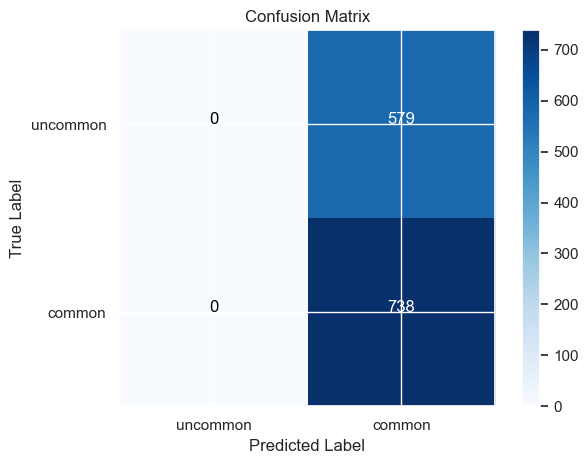

In [26]:
plot_confusion_matrix(y_test, dumb_pred)

We see that it correctly predicts 738 of the common diagnosis and incorrectly predicts 579 for the uncommon diagnosis. This will be our baseline for any other model performance. 

## Modeling<a id='Modeling'></a>

Now let's test a model. We can try Linear Regression first to make sure we can get the machine learning running smoothly and try to make sense of the results. 

In [27]:
#Try linear regression first

logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)
(pd.DataFrame(y_pred, columns= diagnosis, index=y_test_index))

,common
CPSC_Case_Number,
170827787,1
160852455,0
170157166,0
141223560,1
130852418,1
...,...
161044669,1
130902754,1
171106994,1


Based on the results of our prediction, we can see for each case number, whether the expected diagnosis is common or not.

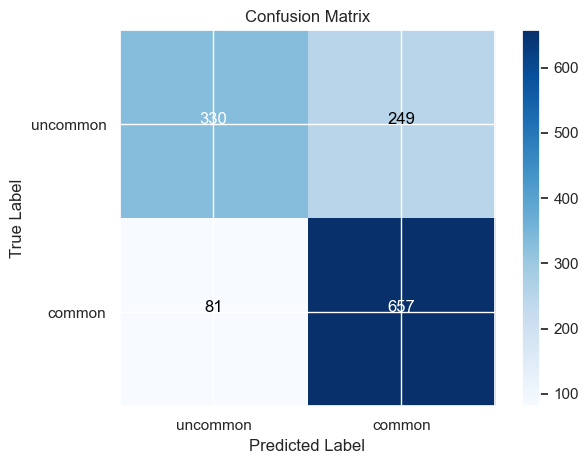

In [28]:
plot_confusion_matrix(y_test, y_pred)

After looking at the confusion matrix, we see that the model correct predicted 657 of the common diagnosis, and 330 of the uncommon diagnosis. It incorrectly thought 249 uncommon Diagnosis were actually common and 81 common diagnosis as uncommon. 

## Conclusion<a id='Conclusion'></a>

In this notebook, we were able to create dummy columns for categorical variables, split the data into traning and testing sets, standardize numerical values, and tested a logistical regression model. We split the Diagnosis column into 2 categories, common and uncommon. We also created a baseline model using the mean to predict different diagnosis. We displayed the results in confusion matrixes to find that the baseline model correctly predicts 738 of the common diagnosis and incorrectly predicts 579 for the uncommon diagnosis. Our logistic regression model correctly predicted 657 of the common diagnosis, and 330 of the uncommon diagnosis. It incorrectly predicted 249 uncommon Diagnosis that were actually common and 81 common diagnosis as uncommon.